Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/regression/auto-ml-regression.png)

# Automated Machine Learning
_**Regression with Aml Compute**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)



## Introduction
In this example we use the Hardware Performance Dataset to showcase how you can use AutoML for a simple regression problem. The Regression goal is to predict the performance of certain combinations of hardware parts.

If you are using an Azure Machine Learning Compute Instance, you are all set.  Otherwise, go through the [configuration](../../../configuration.ipynb)  notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an `Experiment` in an existing `Workspace`.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Test the best fitted model.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
%env AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
%env AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true

env: AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
env: AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true


In [46]:
import azure.ml
from azure.ml import MLClient

from azure.core.exceptions import ResourceExistsError

from azure.ml.entities import Workspace
from azure.ml.entities import AmlCompute
from azure.ml.entities import Data

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [3]:
# TODO: Versions need to change
print("This notebook was created using version 1.31.0 of the Azure ML SDK")
print("You are currently using SDK version", azure.ml.version.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.31.0 of the Azure ML SDK
You are currently using SDK version 0.0.86 of the Azure ML SDK


In [6]:
subscription_id = '381b38e9-9840-4719-a5a0-61d9585e1e91'
resource_group_name = 'gasi_rg_centraleuap'
workspace_name = "gasi_ws_centraleuap"
experiment_name = "automl-regression"

client = MLClient(subscription_id, resource_group_name, default_workspace_name=workspace_name)

client

In [7]:
import mlflow

########
# TODO: The API to get tracking URI is not yet available on Worksapce object.
from azureml.core import Workspace as WorkspaceV1
ws = WorkspaceV1(workspace_name=workspace_name, resource_group=resource_group_name, subscription_id=subscription_id)
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
del ws
########

# Not sure why this doesn't work w/o the double + single quotes
# mlflow.set_tracking_uri("azureml://northeurope.experiments.azureml.net/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_neu/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_neu?")
mlflow.set_experiment(experiment_name)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))

INFO: 'automl-regression' does not exist. Creating a new experiment

Current tracking uri: azureml://master.experiments.azureml-test.net/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap?


### Using AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for your AutoML run. In this tutorial, you use `AmlCompute` as your training compute resource.

In [9]:
# Set or create compute

cpu_cluster_name = "cpu-cluster"
compute = AmlCompute(
    name=cpu_cluster_name, size="STANDARD_D2_V2",
    min_instances=0, max_instances=3,
    idle_time_before_scale_down=120
)

# Load directly from YAML file
# compute = Compute.load("./compute.yaml")

try:
    # TODO: This currently results in an exception in Azure ML, please create compute manually.
    client.compute.create(compute)
except ResourceExistsError as re:
    print(re)
except Exception as e:
    import traceback
    
    print("Could not create compute.", str(e))
#     traceback.print_exc()
    # Reload an existing compute target
    compute = client.compute.get(cpu_cluster_name)

compute

Could not create compute. Cannot deserialize duration object., ISO8601Error: Unable to parse duration string ''


AmlCompute({'name': 'cpu-cluster', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/computes/cpu-cluster', 'description': None, 'tags': {}, 'properties': {}, 'base_path': './', 'location': 'centraluseuap', 'type': 'amlcompute', 'enable_public_ip': False, 'resource_id': None, 'provisioning_state': 'Succeeded', 'provisioning_errors': None, 'created_on': None, 'size': 'STANDARD_D2_V2', 'min_instances': 0, 'max_instances': 4, 'idle_time_before_scale_down': 120.0, 'identity_type': None, 'user_assigned_identities': None, 'admin_username': 'azureuser', 'admin_password': None, 'ssh_key_value': None, 'vnet_name': None, 'subnet': None, 'priority': 'Dedicated'})

## Data


### Load Data
Load the hardware dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model. 

In [13]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/machineData.csv"
pdf = pd.read_csv(data)

# 80/20 split
train=pdf.sample(frac=0.8, random_state=42)
test=pdf.drop(train.index)

label = "ERP"
train.shape, test.shape

((167, 10), (42, 10))

In [14]:
# Save the CSV file locally, so that it can be uploaded to create a 
# tabular dataset

import os

if not os.path.isdir('data'):
    os.mkdir('data')
    
# Save the train-test-valid data to a csv to be uploaded to the datastore
train.to_csv("data/train_data.csv", index=False)

In [15]:
# TODO: This doesnt' work, ensure dataset is created via. the UI
# Create dataset

dataset_name = "machine_data_train"
dataset_version = 1

try:
    training_data = client.data.get(dataset_name, dataset_version)
#     training_data = Data(name=dataset_name, version=dataset_version, local_path="./data")
#     training_data = client.data.create_or_update(training_data)
#     print("Uploaded to path  : ", data.path)
#     print("Datastore location: ", data.datastore)
except Exception as e:
    print("Could not create dataset. ", str(e))

training_data

Data({'is_anonymous': False, 'name': 'machine_data_train', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/data/machine_data_train/versions/1', 'description': None, 'tags': {}, 'properties': {}, 'base_path': './', 'creation_context': <azure.ml._restclient.v2021_03_01_preview.models._models_py3.SystemData object at 0x7fd4a87b7810>, 'version': 1, 'datastore': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/datastores/workspaceblobstore', 'path': 'UI/07-14-2021_062933_UTC/train_data.csv', 'local_path': None})

## Train

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification, regression or forecasting|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|(sparse) array-like, shape = [n_samples, n_features]|
|**label_column_name**|(sparse) array-like, shape = [n_samples, ], targets values.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [19]:
from azure.ml._restclient.v2020_09_01_preview.models import (
    GeneralSettings,
    DataSettings,
    LimitSettings,
    TrainingDataSettings,
    ValidationDataSettings,
    TestDataSettings,
    FeaturizationSettings,
)

from azure.ml.entities._job.automl.training_settings import TrainingSettings
from azure.ml.entities import AutoMLJob, ComputeConfiguration
    
        
compute_settings = ComputeConfiguration(target=cpu_cluster_name)

general_settings = GeneralSettings(
    task_type="regression",
    primary_metric= "r2_score",
    log_verbosity="Info")

limit_settings = LimitSettings(
    timeout=20,
    trial_timeout=5,
    max_concurrent_trials=4,
    max_cores_per_trial=-1,
    enable_early_termination=True)

training_data_settings = TrainingDataSettings(
    dataset_arm_id="{}:{}".format(training_data.name, training_data.version)
)

validation_data_settings = ValidationDataSettings(n_cross_validations=3)

data_settings = DataSettings(
    training_data=training_data_settings,
    target_column_name=label,
    validation_data=validation_data_settings
)

extra_automl_settings = {"save_mlflow": True}

automl_job = AutoMLJob(
    compute=compute_settings,
    general_settings=general_settings,
    limit_settings=limit_settings,
    data_settings=data_settings,
    properties=extra_automl_settings,
)

automl_job

AutoMLJob({'name': 'cd4b8223-6765-4a6f-b418-7315d184c305', 'id': None, 'description': None, 'tags': {}, 'properties': {'save_mlflow': True}, 'base_path': './', 'type': 'automl_job', 'creation_context': None, 'experiment_name': 'regression', 'status': None, 'interaction_endpoints': None, 'log_files': None, 'output': None, 'general_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.GeneralSettings object at 0x7fd47399e7d0>, 'data_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.DataSettings object at 0x7fd47399e810>, 'limit_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.LimitSettings object at 0x7fd47399e790>, 'forecasting_settings': None, 'training_settings': None, 'featurization_settings': None, 'compute': {'instance_count': None, 'target': 'cpu-cluster', 'is_local': False, 'instance_type': None, 'location': None, 'properties': None}})

Call the `submit` method on the experiment object and pass the run configuration. Execution of remote runs is asynchronous. Depending on the data and the number of iterations this can run for a while.  Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [20]:
created_job = client.jobs.create_or_update(automl_job)
created_job

HttpResponseError: Operation returned an invalid status 'Received 500 from a service request'

In [ ]:
# If you need to retrieve a run that already started, use the following code
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment = experiment, run_id = '<replace with your run id>')

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [ ]:
# from azureml.widgets import RunDetails
# RunDetails(remote_run).show() 

In [ ]:
# remote_run.wait_for_completion()

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [24]:
from mlflow.tracking import MlflowClient

# TODO: Use this run, as it has MLFlow model stored on the run
job_name = "AutoML_63a6198d-fd94-415c-89a8-2d774e63a0c2"
# job_name = created_job.name

mlflow_client = MlflowClient()
mlflow_parent_run = mlflow_client.get_run(job_name)

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)
best_run

Found best child run id:  AutoML_63a6198d-fd94-415c-89a8-2d774e63a0c2_30


<Run: data=<RunData: metrics={'explained_variance': 0.9469377156576257,
 'mean_absolute_error': 16.344931726318706,
 'mean_absolute_percentage_error': 13.440869393270205,
 'median_absolute_error': 4.962546667916155,
 'normalized_mean_absolute_error': 0.013364621198952334,
 'normalized_median_absolute_error': 0.004057683293471918,
 'normalized_root_mean_squared_error': 0.031322641934272775,
 'normalized_root_mean_squared_log_error': 0.03984624176365959,
 'r2_score': 0.9432604716952184,
 'root_mean_squared_error': 38.307591085615606,
 'root_mean_squared_log_error': 0.17331007936109333,
 'spearman_correlation': 0.9783322136381037}, params={}, tags={'_aml_system_ComputeTargetStatus': '{"AllocationState":"steady","PreparingNodeCount":0,"RunningNodeCount":2,"CurrentNodeCount":4}',
 '_aml_system_automl_is_child_run_end_telemetry_event_logged': 'True',
 '_aml_system_azureml.automlComponent': 'AutoML',
 'mlflow.parentRunId': 'AutoML_63a6198d-fd94-415c-89a8-2d774e63a0c2',
 'mlflow.source.name': 

In [27]:
# This step requires AutoML runtime libraries to be installed
# !pip install azureml-train-automl-runtime

import mlflow.sklearn

fitted_model = mlflow.sklearn.load_model("runs:/{}/outputs".format(best_run.info.run_id))

#### Best Model Based on Any Other Metric
Show the run and the model that has the smallest `root_mean_squared_error` value (which turned out to be the same as the one with largest `spearman_correlation` value):

In [36]:
# Search all child runs with a parent id
lookup_metric = "root_mean_squared_error"

experiment = mlflow_client.get_experiment_by_name(experiment_name)
print(experiment)

###########################################################################################
# Steps:
# 1. Get all child runs for the parent run, filtered on runs that have ONNX resource on the properties, 
# & sorted on primary metrics
# 2. Take the head of that list - which will be the best ONNX model

# TODO: This filter should work - but currently, the child runs don't have this tag set.
# The single quotes around 'mlflow.parentRunId' are required due to a bug in AzureML MLFlow.
query = "tags.'mlflow.parentRunId' = '{}'".format(mlflow_parent_run.info.run_id)
best_run = mlflow_client.search_runs(
    experiment_ids=experiment.experiment_id,
    filter_string=query,
    max_results=1,
    order_by=["metrics.{} DESC".format(lookup_metric)]
)[0]
fitted_model = mlflow.sklearn.load_model("runs:/{}/outputs".format(best_run.info.run_id))
###########################################################################################

print(best_run)
print(fitted_model)

<Experiment: artifact_location='', experiment_id='290cdf52-a0af-44fb-9476-ca40c53aca26', lifecycle_stage='active', name='automl-regression', tags={}>


IndexError: list index out of range

#### Model from a Specific Iteration
Show the run and the model from the third iteration:

In [32]:
iteration = 3

child_run_id = "{}_{}".format(mlflow_parent_run.info.run_id, (iteration-1))

third_run = mlflow_client.get_run(child_run_id)
third_model = mlflow.sklearn.load_model("runs:/{}/outputs".format(third_run.info.run_id))

print(third_run)
print(third_model)

<Run: data=<RunData: metrics={'explained_variance': 0.624792993161615,
 'mean_absolute_error': 44.20391835019664,
 'mean_absolute_percentage_error': 34.743183855204464,
 'median_absolute_error': 11.70712295125024,
 'normalized_mean_absolute_error': 0.0361438416600136,
 'normalized_median_absolute_error': 0.009572463574202975,
 'normalized_root_mean_squared_error': 0.08395852618755467,
 'normalized_root_mean_squared_log_error': 0.09960305284029425,
 'r2_score': 0.5883550193705834,
 'root_mean_squared_error': 102.68127752737938,
 'root_mean_squared_log_error': 0.43322060571599447,
 'spearman_correlation': 0.8662864781197537}, params={}, tags={'_aml_system_ComputeTargetStatus': '{"AllocationState":"steady","PreparingNodeCount":0,"RunningNodeCount":2,"CurrentNodeCount":3}',
 '_aml_system_automl_is_child_run_end_telemetry_event_logged': 'True',
 '_aml_system_azureml.automlComponent': 'AutoML',
 'mlflow.parentRunId': 'AutoML_63a6198d-fd94-415c-89a8-2d774e63a0c2',
 'mlflow.source.name': 'auto

## Test

In [41]:
y_test = test['ERP']
test_data = test.drop('ERP', axis=1)


y_train = train['ERP']
train_data = train.drop('ERP', axis=1)

print(y_test.shape, test_data.shape)
print(y_train.shape, train_data.shape)

(42,) (42, 9)
(167,) (167, 9)


In [42]:
y_pred_train = fitted_model.predict(train_data)
y_residual_train = y_train.values - y_pred_train

y_pred_test = fitted_model.predict(test_data)
y_residual_test = y_test.values - y_pred_test

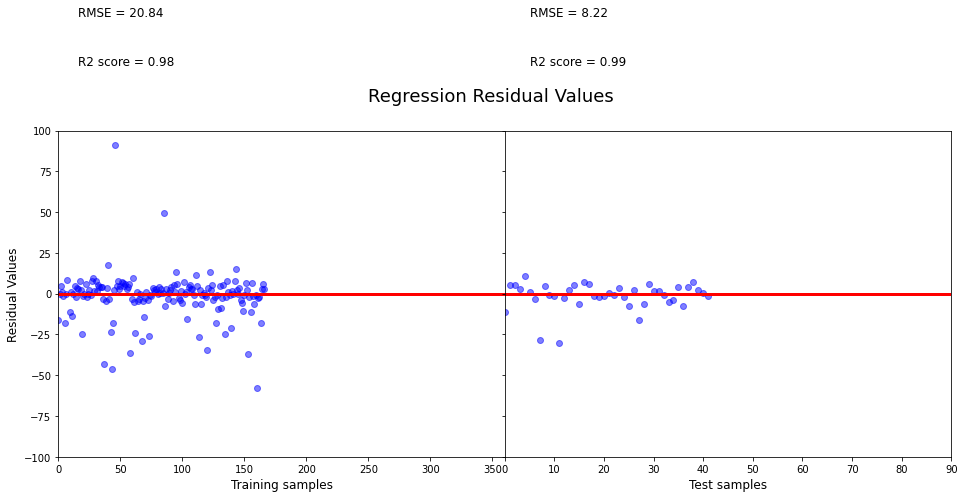

In [47]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -100, 100])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)),fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot residual values of test set.
a1.axis([0, 90, -100, 100])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)),fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

plt.show()

ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

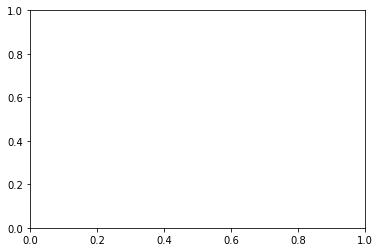

In [48]:
%matplotlib inline
test_pred = plt.scatter(y_test, y_pred_test, color='')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()